# Sentiment Analysis on Instagram Comments
## Master's Thesis in Data Science
### Autor: Florencia Federico
This project performs sentiment analysis on Instagram comments using a multilingual RoBERTa model fine-tuned for social media text. It combines rule-based emoji heuristics with machine learning to accurately classify comments as positive, neutral, or negative. Results are stored back into a SQL Server database for further analysis.

### 📚 Imports and Configuration

In [45]:
import pandas as pd
import pyodbc
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from scipy.special import softmax
import emoji
from time import time
import regex as re
import warnings

warnings.filterwarnings("ignore")


### 📥 Load Comments

In [46]:
df = pd.read_csv("../data/dataset_sentiment.csv")
df.head()


,artist_id,comment_id,text,datetime
0,436lvfnz,17937099560207698,Amor da geo,2022-07-05 08:53:36.000
1,436lvfnz,17914067000479365,😍😍😍😍😍,2022-07-05 08:53:40.000
2,436lvfnz,17976550423533555,😍😍,2022-07-05 08:59:16.000
3,436lvfnz,17871283712723000,Blesss 👏🏼,2022-07-05 09:10:20.000
4,436lvfnz,17962194565819384,Prince of RnB.....our King is doing 30 yrs rn 😢,2022-07-05 11:14:20.000


### 🤗 Load RoBERTa Sentiment Model

In [47]:
MODEL = "cardiffnlp/twitter-xlm-roberta-base-sentiment"
print("[INFO] Loading model...")

tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

print("[INFO] Model loaded.")


[INFO] Loading model...
[INFO] Model loaded.


### 😄 Emoji Lists

In [48]:
positive_emojis = ['😍','😎','😊','🤩','🔥','💯','👏','😁','😄','😃','🍭','🥰','😘','☺️','😚','👍','✨','🙌','😆','😺','😸','👑',
                   '🎉','🎊','🌟','🎶','🤗','🏆','🎵','🎼','😇','😋','🤭','🌈','❤️','🧡','💛','💚','💙','💜','🤎','🚀','💘','🍾',
                   '🖤','🤍','💕','💖','💗','💓','💞','💝','💟','🌹','♥️','😂']

negative_emojis = ['😡','😠','🤮','💩','👎','😭','😢','😿','😾','😤','😒','😞','😩','😫','🙄','😖','😔','💔','😓','😕','🤬',
                   '😣','😬','🥵','🥶','🖕','😶‍🌫️','☹️','🙁','😧','😱','😨','😰','😳','😥']


### 🧩 Helper Functions for Emoji Sentiment

In [49]:
def extract_emojis(text):
    emoji_pattern = re.compile(r'\X', re.UNICODE)
    return [e for e in emoji_pattern.findall(text) if e in positive_emojis + negative_emojis]

def has_only_emojis(text, emoji_list):
    if not text:
        return False
    emojis = extract_emojis(text.replace(" ", ""))
    return len(emojis) >= 3 and all(e in emoji_list for e in emojis)

def has_majority_positive(text):
    total = sum(1 for c in text if c in positive_emojis + negative_emojis)
    if total == 0:
        return False
    positive = sum(1 for c in text if c in positive_emojis)
    return positive / total >= 0.7

def short_positive_comment(text):
    return len(text.split()) <= 3 and sum(1 for c in text if c in positive_emojis) >= 1

def short_negative_comment(text):
    return len(text.split()) <= 3 and sum(1 for c in text if c in negative_emojis) >= 1

def few_words_positive_emojis(text):
    return len(text.split()) <= 5 and sum(1 for c in text if c in positive_emojis) >= 3

def few_words_negative_emojis(text):
    return len(text.split()) <= 5 and sum(1 for c in text if c in negative_emojis) >= 3

def has_majority_negative(text):
    total = sum(1 for c in text if c in positive_emojis + negative_emojis)
    if total == 0:
        return False
    negative = sum(1 for c in text if c in negative_emojis)
    return negative / total >= 0.7


### 🧠 Preprocessing and Sentiment Prediction

In [50]:
def preprocess(text):
    return emoji.demojize(text or "")

def predict_sentiment(text):
    if has_only_emojis(text, positive_emojis):
        return 1
    if has_only_emojis(text, negative_emojis):
        return -1
    if few_words_positive_emojis(text):
        return 1
    if few_words_negative_emojis(text):
        return -1
    if has_majority_positive(text):
        return 1
    if has_majority_negative(text):
        return -1
    if short_positive_comment(text):
        return 1
    if short_negative_comment(text):
        return -1

    text = preprocess(text)
    inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=512)
    with torch.no_grad():
        outputs = model(**inputs)
        scores = outputs.logits[0].numpy()
        scores = softmax(scores)
    sentiment_score = scores.argmax()
    return {-1: 0, 0: -1, 1: 0, 2: 1}[sentiment_score]


### 🔁 Apply Sentiment Analysis to All Comments

In [51]:
from time import time

# Asegurarse de que exista la columna antes de asignar
df['sentiment'] = None

start_time = time()

for i, row in df.iterrows():
    try:
        sentiment = predict_sentiment(row['text'])
        df.at[i, 'sentiment'] = sentiment

        if i % 10000 == 0:
            print(f"[{i}/{len(df)}] Processed...")

    except Exception as e:
        print(f"[ERROR] Comment ID {row['comment_id']}: {e}")

print(f"[INFO] Process completed in {round((time() - start_time) / 60, 2)} minutes.")


[0/194740] Processed...
[10000/194740] Processed...
[20000/194740] Processed...
[30000/194740] Processed...
[40000/194740] Processed...
[50000/194740] Processed...
[60000/194740] Processed...
[70000/194740] Processed...
[80000/194740] Processed...
[90000/194740] Processed...
[100000/194740] Processed...
[110000/194740] Processed...
[120000/194740] Processed...
[130000/194740] Processed...
[140000/194740] Processed...
[150000/194740] Processed...
[160000/194740] Processed...
[170000/194740] Processed...
[180000/194740] Processed...
[190000/194740] Processed...
[INFO] Process completed in 91.11 minutes.


### 📤 Export Results and Summary

In [52]:
# Rename column for clarity
df.rename(columns={'sentiment': 'predicted_sentiment'}, inplace=True)

# Export all results to CSV
df.to_csv("../outputs/sentiment_results.csv", index=False)
print("[INFO] Results saved to sentiment_results.csv")


[INFO] Results saved to sentiment_results.csv



[INFO] Sentiment Distribution:
sentiment_label
Positive    135922
Neutral      37601
Negative     21217
Name: count, dtype: int64


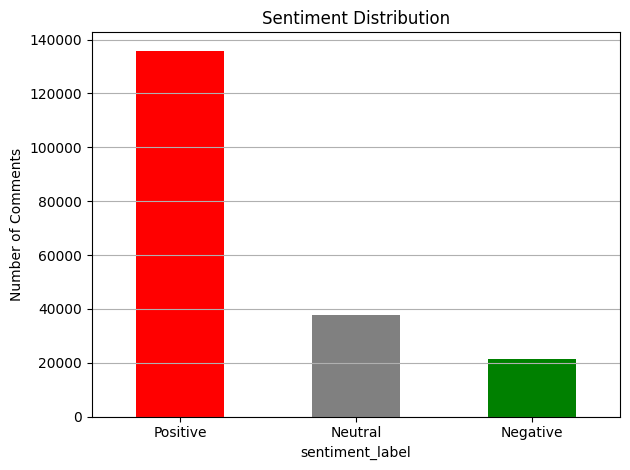

In [53]:
# Replace numeric sentiment values with labels
df['sentiment_label'] = df['predicted_sentiment'].replace({-1: 'Negative', 0: 'Neutral', 1: 'Positive'})

# Print distribution summary
summary = df['sentiment_label'].value_counts()
print("\n[INFO] Sentiment Distribution:")
print(summary)

# Plot the distribution
import matplotlib.pyplot as plt

summary.plot(kind='bar', color=['red', 'gray', 'green'])
plt.title("Sentiment Distribution")
plt.ylabel("Number of Comments")
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.tight_layout()
plt.show()


### 📊 1. Sentiment Distribution per Artist (Stacked Bar Chart)  
Displays the number of negative, neutral, and positive comments per artist.


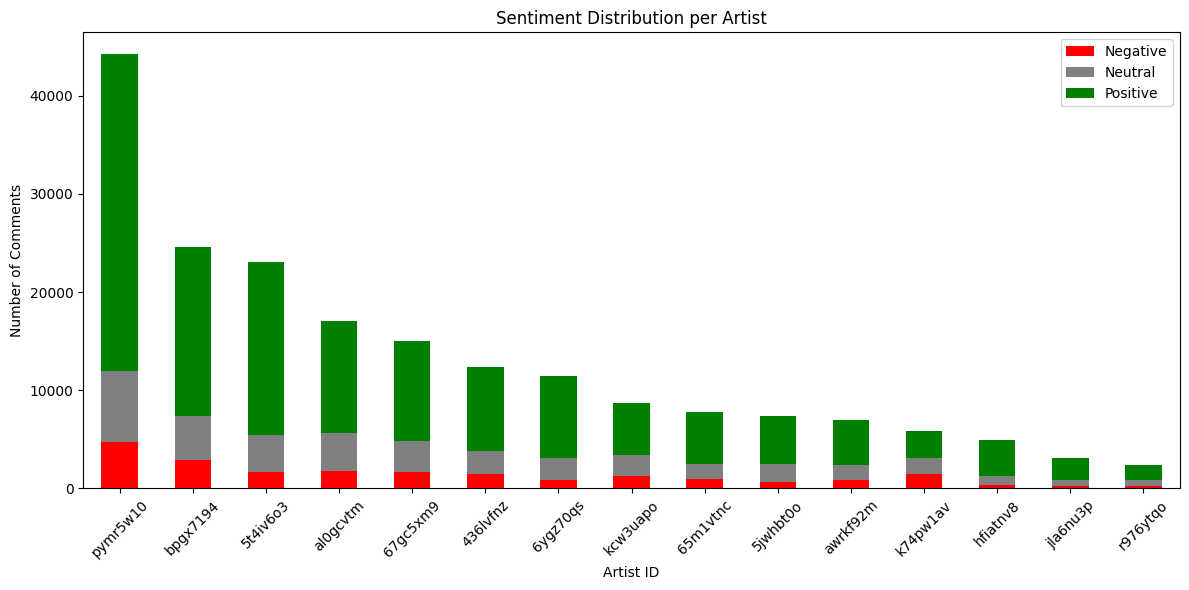

In [54]:
import matplotlib.pyplot as plt

# Agrupar y contar
sentiment_counts = df.groupby(['artist_id', 'predicted_sentiment']).size().unstack(fill_value=0)

# Ordenar artistas con más comentarios
sentiment_counts = sentiment_counts.loc[sentiment_counts.sum(axis=1).sort_values(ascending=False).index]

# Plot
sentiment_counts.plot(kind='bar', stacked=True, figsize=(12, 6), color=['red', 'gray', 'green'])
plt.title("Sentiment Distribution per Artist")
plt.ylabel("Number of Comments")
plt.xlabel("Artist ID")
plt.xticks(rotation=45)
plt.legend(["Negative", "Neutral", "Positive"])
plt.tight_layout()
plt.show()


### 📈 2. Percentage of Positive Comments per Artist  
Ideal for quickly comparing how "well-liked" each artist is.


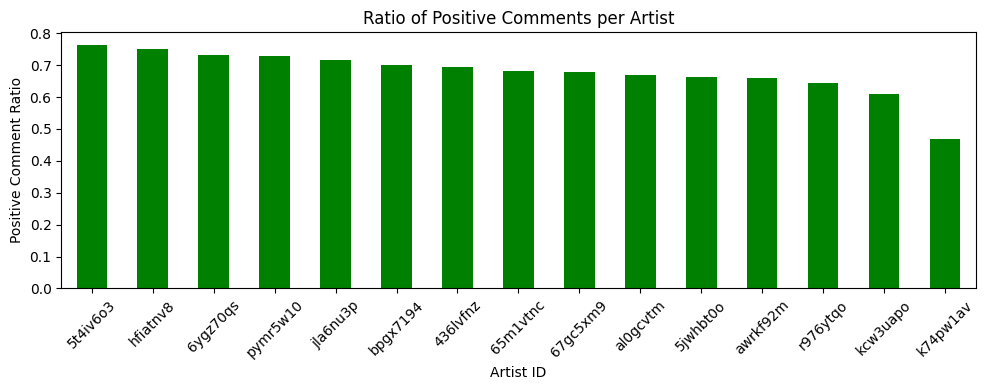

In [55]:
# Convert sentiment values to labels
df['label'] = df['predicted_sentiment'].replace({-1: 'Negative', 0: 'Neutral', 1: 'Positive'})

# Calculate proportion of positive comments per artist
positive_ratio = df[df['label'] == 'Positive'].groupby('artist_id').size() / df.groupby('artist_id').size()

# Plot
positive_ratio.sort_values(ascending=False).plot(kind='bar', color='green', figsize=(10, 4))
plt.title("Ratio of Positive Comments per Artist")
plt.ylabel("Positive Comment Ratio")
plt.xlabel("Artist ID")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


### ⏳ 3. Sentiment Trend Over Time per Artist  
If you have the timestamp, you can analyze the monthly evolution of average sentiment.


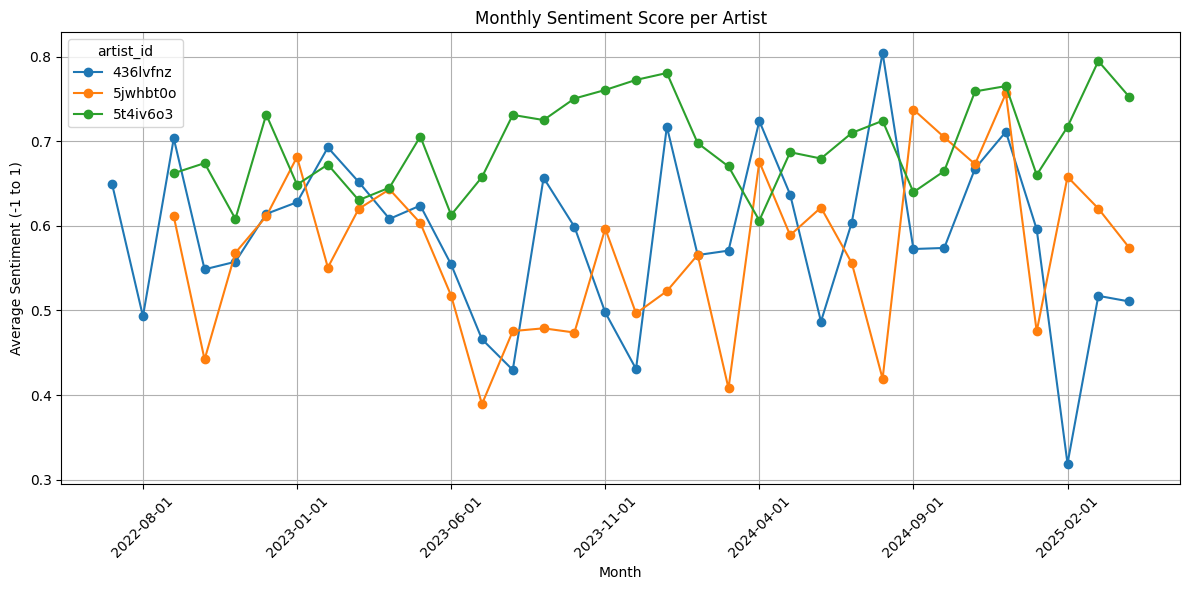

In [56]:
# Ensure datetime is in date format (set to first day of the month)
df['date'] = pd.to_datetime(df['datetime']).dt.to_period('M').astype(str) + '-01'

# Calculate average sentiment per artist and month
monthly_sentiment = df.groupby(['artist_id', 'date'])['predicted_sentiment'].mean().unstack()

# Select one or more real artists from the dataset
selected_artists = df['artist_id'].unique()[:3]  # e.g., first 3 artists
monthly_sentiment.T[selected_artists].plot(figsize=(12, 6), marker='o')

plt.title("Monthly Sentiment Score per Artist")
plt.ylabel("Average Sentiment (-1 to 1)")
plt.xlabel("Month")
plt.xticks(rotation=45)
plt.grid()
plt.tight_layout()
plt.show()


### 🎯 BONUS: Artists with the Most Extreme Comments


In [57]:
top_negative = df[df['predicted_sentiment'] == -1]['artist_id'].value_counts().head(10)
top_positive = df[df['predicted_sentiment'] == 1]['artist_id'].value_counts().head(10)

print("🔴 Top 10 artists with most negative comments:")
print(top_negative)

print("\n🟢 Top 10 artists with most positive comments:")
print(top_positive)


🔴 Top 10 artists with most negative comments:
artist_id
pymr5w10    4681
bpgx7194    2908
al0gcvtm    1809
67gc5xm9    1651
5t4iv6o3    1634
k74pw1av    1516
436lvfnz    1459
kcw3uapo    1258
65m1vtnc     961
awrkf92m     881
Name: count, dtype: int64

🟢 Top 10 artists with most positive comments:
artist_id
pymr5w10    32280
5t4iv6o3    17671
bpgx7194    17156
al0gcvtm    11434
67gc5xm9    10195
436lvfnz     8596
6ygz70qs     8342
65m1vtnc     5295
kcw3uapo     5269
5jwhbt0o     4889
Name: count, dtype: int64
